# SWE pre-processing
This Notebook reads SWE station observations and precipitation station data (SCDNA, 1979-2018 Version 1.1; the complete data is available on Zenodo [here](https://zenodo.org/record/3953310#.YXnGQS1b1mA)) for a test river basin. It fills the gaps in the SWE station observations that are within the river basin, using quantile mapping with neighbouring SWE and precipitation station data.

Decisions:
- We only use SWE and precipitation station data within the test river basin, and do not apply any buffer around the basin. A distance-decay plot could be used to check the optimal buffer size.
- The water year definition is October 1st to September 30th of the next year. See user-specified variables below.
- The minimum correlation allowed to select an optimal donor station is set to 0.6 at the moment (no negative correlations selected). See user-specified variables below.
- The minimum number of overlapping observations required to calculate the correlation between two stations is set to 3 at the moment. See user-specified variables below.
- The minimum number of observations required to calculate a station's cdf is set to 10 at the moment. See user-specified variables below.
- We use a time window of +/- 7 days on either side of the infilling date for gap filling calculations. See user-specified variables below.
- The minimum number of observations required to calculate the KGE'' is set to 3 at the moment. See user-specified variables below.
- We perform a linear interpolation of the daily discharge data before calculating volumes, to fill in small data gap of maximum 15 days. See user-specified variables below.
- We evaluate the artificial gap filling quality based on the RMSE and the KGE'' decomposition.

The "Variables" section below is the only section a user will need to modify for testing different options for most of these decisions.

Notes:
- We do not look at data stationarity.

## Modules, settings & functions

In [1]:
# Import required modules
import datetime
from datetime import timedelta
import geopandas as gpd
import logging
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pprint import pprint
from shapely.geometry import Point
import sys
import warnings
import xarray as xr

In [2]:
# Add scripts to the system path
sys.path.append('../scripts')

# Set up logging, configured for this workflow (see utilities.py)
from utilities import setup_logging, read_settings
setup_logging()

# Set up logging for this notebook
logger = logging.getLogger()

# Suppress misc. comments from being added to the log file
logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.pyplot').disabled = True

# Get the logger for fiona._env and suppress everything below CRITICAL level
fiona_env_logger = logging.getLogger('fiona._env')
fiona_env_logger.setLevel(logging.CRITICAL)

%load_ext autoreload
%autoreload 2

2024-10-22 13:59:01,380 - root - INFO - Logging setup complete. Log file: C:\Users\lauri\PycharmProjects\FROSTBYTE\logs\data_driven_forecasting_20241022_135901.log


In [3]:
# Save Notebook name to the log file
logger.debug(f'Notebook: 3_SWEPreprocessing')

In [4]:
# Read settings file
settings = read_settings('../settings/config_test_case.yaml', log_settings=True)
pprint(settings)

2024-10-22 13:59:04,002 - root - INFO - Settings logged from ../settings/config_test_case.yaml


{'SWE_obs_path': '../CH_data/CH_input_data/SWE_data.nc',
 'basins_dem_path': '../test_case_data/input_data/MERIT_Hydro_dem_',
 'basins_shp_path': '../test_case_data/input_data/basins_testcases.shp',
 'domain': '2327',
 'output_data_path': '../CH_data/CH_output_data/',
 'plots_path': '../CH_data/CH_output_plots/',
 'precip_obs_path': '../CH_data/CH_input_data/P_data.nc',
 'streamflow_obs_path': '../CH_data/CH_input_data/Qobs_Camels.nc'}


In [5]:
# Import required functions
from functions import extract_stations_in_basin, stations_basin_map, data_availability_monthly_plots_1, data_availability_monthly_plots_2, qm_gap_filling, artificial_gap_filling, plots_artificial_gap_evaluation

## Variables

In [6]:
# Set user-specified variables
test_basin_id = settings['domain'] # Can override this with testbasin_id = <string of the testbasin id>, make sure that this id is in the input data files
flag_buffer_default, buffer_km_default = 0, 0 # buffer flag (0: no buffer around test basin, 1: buffer of value buffer_default around test basin) and buffer default value in km to be applied if flag = 1
month_start_water_year_default, day_start_water_year_default = 10, 1  # water year start
month_end_water_year_default, day_end_water_year_default = 9, 30  # water year end
min_obs_corr_default = 3 # the minimum number of overlapping observations required to calculate the correlation between 2 stations
min_obs_cdf_default = 10 # the minimum number of observations required to calculate a station's cdf
min_corr_default = 0.6 # the minimum correlation value required for donor stations to be selected
window_days_default = 7 # the number of days used on either side of the infilling date for gap filling calculations
min_obs_KGE_default = 3 # the minimum number of observations required to calculate the KGE''
max_gap_days_default = 15  # max. number of days for gaps allowed in the daily SWE data for the linear interpolation
iterations_default = 1 # the number of times we repeat the artificial gap filling (this should = 1 if artificial_gap_perc_default = 100, if artificial_gap_perc_default < 100, it can be set to > 1)
artificial_gap_perc_default = 100 # the percentage of observations to remove during the artificial gap filling for each station & month's first day

In [7]:
# Save the user-specified variables to the log file
logger.debug(f'test basin ID: {test_basin_id}')
logger.debug(f'buffer around basin for SWE and precip. stations selection (km): {buffer_km_default}')
logger.debug(f'water year start (month/day): {month_start_water_year_default}/{day_start_water_year_default}')
logger.debug(f'water year end (month/day): {month_end_water_year_default}/{day_end_water_year_default}')
logger.debug(f'min. number of obs. for correlation calculation: {min_obs_corr_default}')
logger.debug(f'min. number of obs. for building CDF: {min_obs_cdf_default}')
logger.debug(f'min. Pearson correlation for selection of donor stations: {min_corr_default}')
logger.debug(f'window length for infilling (days on either side of date): {window_days_default}')
logger.debug(f'min. number of obs. for KGE" calculation: {min_obs_KGE_default}')
logger.debug(f'linear interpolation maximum gap (days): {max_gap_days_default}')
logger.debug(f'percentage of observations to remove for artificial gap filling: {artificial_gap_perc_default}')

## Read data

In [8]:
# Read SWE station observations NetCDF
SWE_stations_ds = xr.open_dataset(settings['SWE_obs_path'])
SWE_stations_ds = SWE_stations_ds.assign_coords({'lon':SWE_stations_ds.lon, 'lat':SWE_stations_ds.lat, 'station_id':SWE_stations_ds.station_id}).swe
#SWE_stations_ds = SWE_stations_ds.assign_coords({'lon':SWE_stations_ds.lon, 'lat':SWE_stations_ds.lat, 'station_name':SWE_stations_ds.station_name}).snw
SWE_stations_ds = SWE_stations_ds.to_dataset()

display(SWE_stations_ds)

<xarray.Dataset>
Dimensions:  (lat: 272, lon: 365, time: 8704)
Coordinates:
  * lon      (lon) float64 4.74e+05 4.75e+05 4.76e+05 ... 8.37e+05 8.38e+05
  * lat      (lat) float64 5.3e+04 5.4e+04 5.5e+04 ... 3.23e+05 3.24e+05
  * time     (time) datetime64[ns] 1998-09-01 1998-09-02 ... 2022-06-30
Data variables:
    swe      (time, lat, lon) float64 ...

In [13]:
#Anpassung 10.10.24 SWE_Camels_testbasin_id speichern --> PCA funktioniert nicht mit nur einer Datenreihe
# --> entkomentieren zur visualisierung das es mit camels nicht funktioniert --> gleichzeitig müsste im 4_ die zelle mit diesem datum entkomentiert werden
#SWE_testbasin_ds = SWE_stations_ds.where(SWE_stations_ds.station_id==test_basin_id, drop=True)
#SWE_testbasin_ds = SWE_testbasin_ds.set_index({"station_id":"station_id"})
#output_filename = f"SWE_Camels_{test_basin_id}.nc"
#SWE_testbasin_ds.to_netcdf(f"{settings['output_data_path']}{output_filename}")

In [14]:
# Convert SWE stations DataArray to GeoDataFrame for further analysis
"""
data = {'station_id': SWE_stations_ds.station_id.data, 
        'lon': SWE_stations_ds.lon.data, 
        'lat': SWE_stations_ds.lat.data} 
df = pd.DataFrame(data)
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
crs = "EPSG:4326"
SWE_stations_gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

display(SWE_stations_gdf)
"""
print(SWE_stations_ds.station_id.data.shape)
print(SWE_stations_ds.lon.data.shape)
print(SWE_stations_ds.lat.data.shape)
data = {'station_id': SWE_stations_ds.station_id.data, 
        'lon': SWE_stations_ds.lon.data, 
        'lat': SWE_stations_ds.lat.data} 
df = pd.DataFrame(data)
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
crs = "EPSG:4326"
SWE_stations_gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

display(SWE_stations_gdf)

AttributeError: 'Dataset' object has no attribute 'station_id'

<IPython.core.display.Javascript object>


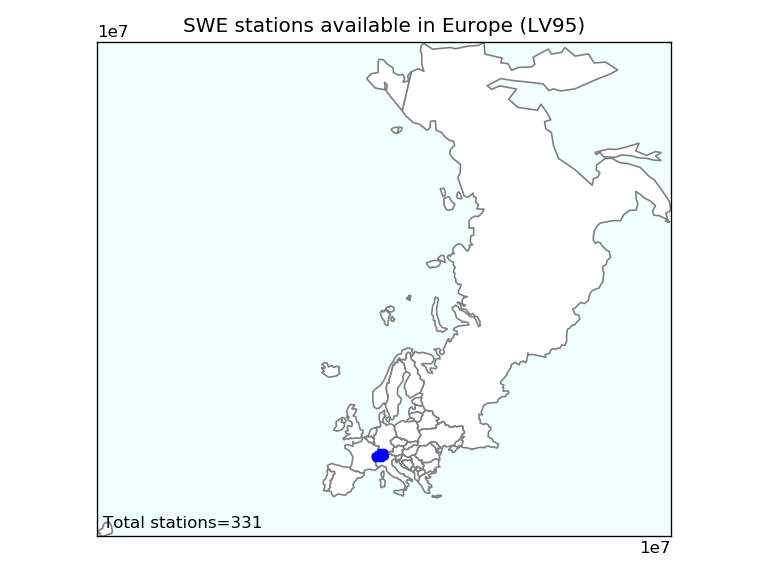

'\nworld_gdf = gpd.read_file(gpd.datasets.get_path(\'naturalearth_lowres\'))\nNA_albers_gdf = world_gdf[world_gdf[\'continent\']==\'North America\'].to_crs("ESRI:102008")\nax = NA_albers_gdf.plot(linewidth=1, edgecolor=\'grey\', color=\'white\')\nSWE_stations_albers_gdf = SWE_stations_gdf.copy().to_crs("ESRI:102008")\nSWE_stations_albers_gdf.plot(ax=ax, color=\'b\', alpha=.5, markersize=5)             \nminx, miny, maxx, maxy = np.nanmin(NA_albers_gdf.geometry.bounds.minx),np.nanmin(NA_albers_gdf.geometry.bounds.miny),np.nanmax(NA_albers_gdf.geometry.bounds.maxx),np.nanmax(NA_albers_gdf.geometry.bounds.maxy)\nax.set_xlim(minx, maxx)\nax.set_ylim(miny, maxy)\nax.margins(0)\nax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)\nax.set_facecolor(\'azure\')\nplt.title(\'SWE stations available\')\nplt.text(.01, .01,\'Total stations=\'+str(len(SWE_stations_albers_gdf.index)), ha=\'left\', va=\'bottom\', transform=ax.transAxes)\nplt.tight_layout();\n'

In [21]:
# Plot SWE stations available

# Laden der Weltkarte
world_gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter für Europa anwenden
EU_albers_gdf = world_gdf[world_gdf['continent'] == 'Europe']

# Umwandeln ins LV95-Koordinatensystem (EPSG:2056)
EU_LV95_gdf = EU_albers_gdf.to_crs(epsg=2056)

# Plot der Europa-Karte im Schweizer Koordinatensystem LV95
ax = EU_LV95_gdf.plot(linewidth=1, edgecolor='grey', color='white')

# Annahme: SWE_stations_gdf ist bereits geladen
# Umprojektion der SWE-Stationen in das LV95-Koordinatensystem
SWE_stations_LV95_gdf = SWE_stations_gdf.copy().to_crs(epsg=2056)

# Plot der SWE-Stationen auf der Europa-Karte
SWE_stations_LV95_gdf.plot(ax=ax, color='b', alpha=.5, markersize=5)

# Kartengrenzen setzen, basierend auf den minimalen und maximalen Koordinaten in Europa
minx, miny, maxx, maxy = np.nanmin(EU_LV95_gdf.geometry.bounds.minx), np.nanmin(EU_LV95_gdf.geometry.bounds.miny), np.nanmax(EU_LV95_gdf.geometry.bounds.maxx), np.nanmax(EU_LV95_gdf.geometry.bounds.maxy)
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot-Details anpassen
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax.set_facecolor('azure')
plt.title('SWE stations available in Europe (LV95)')
plt.text(.01, .01, 'Total stations=' + str(len(SWE_stations_LV95_gdf.index)), ha='left', va='bottom', transform=ax.transAxes)
plt.tight_layout()

plt.show()



"""
world_gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
NA_albers_gdf = world_gdf[world_gdf['continent']=='North America'].to_crs("ESRI:102008")
ax = NA_albers_gdf.plot(linewidth=1, edgecolor='grey', color='white')
SWE_stations_albers_gdf = SWE_stations_gdf.copy().to_crs("ESRI:102008")
SWE_stations_albers_gdf.plot(ax=ax, color='b', alpha=.5, markersize=5)             
minx, miny, maxx, maxy = np.nanmin(NA_albers_gdf.geometry.bounds.minx),np.nanmin(NA_albers_gdf.geometry.bounds.miny),np.nanmax(NA_albers_gdf.geometry.bounds.maxx),np.nanmax(NA_albers_gdf.geometry.bounds.maxy)
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax.set_facecolor('azure')
plt.title('SWE stations available')
plt.text(.01, .01,'Total stations='+str(len(SWE_stations_albers_gdf.index)), ha='left', va='bottom', transform=ax.transAxes)
plt.tight_layout();
"""

You can zoom into the map with the rectangle icon ("zoom to rectangle") showing below the figure. Here, you see that the sample data contains SWE station observations for an area around two river basins, one in the USA and one in Canada, for which we also have all the data needed to run this workflow (e.g., discharge observations).

In [22]:
# Read meteorological station observations NetCDF
met_stations_ds = xr.open_dataset(settings['precip_obs_path'])

display(met_stations_ds)

<xarray.Dataset>
Dimensions:           (Station_ID: 331, time: 14610)
Coordinates:
  * time              (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2020-12-31
  * Station_ID        (Station_ID) object '2004' '2007' '2009' ... '6010' '6011'
    lon               (Station_ID) float64 ...
    lat               (Station_ID) float64 ...
Data variables:
    discharge_vol     (time, Station_ID) float64 ...
    waterlevel        (time, Station_ID) float64 ...
    precipitation     (time, Station_ID) float64 ...
    temperature_min   (time, Station_ID) float64 ...
    temperature_mean  (time, Station_ID) float64 ...
    temperature_max   (time, Station_ID) float64 ...
    rel_sun_dur       (time, Station_ID) float64 ...
    swe               (time, Station_ID) float64 ...

In [23]:
# Convert meteorological stations DataSet to GeoDataFrame for further analysis
data = {'lon': met_stations_ds.LLE.data[1], 
        'lat': met_stations_ds.LLE.data[0],
        'elev': met_stations_ds.LLE.data[2]} 
df = pd.DataFrame(data)
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
met_stations_gdf = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)

display(met_stations_gdf)

AttributeError: 'Dataset' object has no attribute 'LLE'

<IPython.core.display.Javascript object>


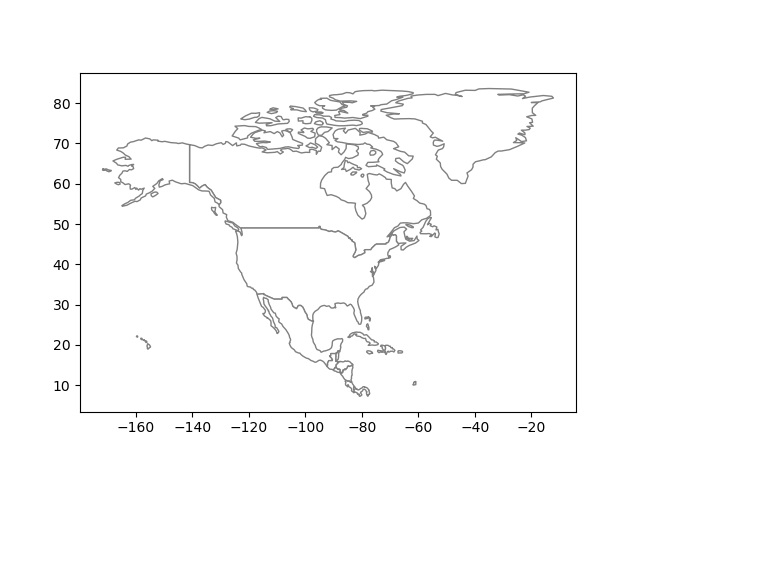

NameError: name 'met_stations_gdf' is not defined

In [24]:
# Plot meteorological stations available
NA_gdf = world_gdf[world_gdf['continent']=='North America']
ax = NA_gdf.plot(linewidth=1, edgecolor='grey', color='white')
plt.scatter(met_stations_gdf.lon, met_stations_gdf.lat, color='b', alpha=.5, s=5)
minx, miny, maxx, maxy = np.nanmin(NA_gdf.geometry.bounds.minx),np.nanmin(NA_gdf.geometry.bounds.miny),np.nanmax(NA_gdf.geometry.bounds.maxx),np.nanmax(NA_gdf.geometry.bounds.maxy)
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax.set_facecolor('azure')
plt.title('Meteorological stations available')
plt.text(.01, .01,'Total stations='+str(len(met_stations_gdf.index)), ha='left', va='bottom', transform=ax.transAxes)
plt.tight_layout();

Same comments as for the SWE map above. Note that not all meteorological stations contained in this dataset have precipitation data. Some only have temperature for example. We will sort out the stations with precipitation later in this workflow.

## Extract SWE and precipitation stations in the basin

In [25]:
# Read test basin's shapefile
basins_gdf = gpd.read_file(settings['basins_shp_path'])
shp_testbasin_gdf = basins_gdf.loc[basins_gdf.Station_ID == test_basin_id]

display(shp_testbasin_gdf)

,Station_ID,Station_Na,Area_km2,Source,geometry


In [26]:
# Plot a map of the test basin and of the SWE and meteorological stations available
fig = stations_basin_map(shp_testbasin_gdf, test_basin_id, SWE_stations_gdf, met_stations_gdf, flag=flag_buffer_default, buffer_km=buffer_km_default)

NameError: name 'met_stations_gdf' is not defined

We will now extract the SWE and meteorological stations that fall within the basin only.

In [16]:
# Extract SWE stations within test basin (+ optional buffer) and save info to DataFrame
SWE_stations_in_basin = extract_stations_in_basin(SWE_stations_gdf, shp_testbasin_gdf, test_basin_id, buffer_km=buffer_km_default)[0]

display(SWE_stations_in_basin)

print('There are',str(len(SWE_stations_in_basin.index)),'SWE stations within the test basin.')

,station_id,lon,lat,geometry,basin
0,ALE-05BA811,-116.466667,51.700001,POINT (-116.46667 51.70000),05BB001
9,SCD-AL003,-115.566666,51.183334,POINT (-115.56667 51.18333),05BB001
39,ALE-05BA801,-116.183334,51.416668,POINT (-116.18333 51.41667),05BB001
40,ALE-05BA802,-116.166664,51.433334,POINT (-116.16666 51.43333),05BB001
41,ALE-05BA806,-116.233330,51.416668,POINT (-116.23333 51.41667),05BB001
42,ALE-05BA808,-116.216667,51.416668,POINT (-116.21667 51.41667),05BB001
43,ALE-05BA810,-116.099998,51.466667,POINT (-116.10000 51.46667),05BB001
44,ALE-05BA812,-116.216667,51.316666,POINT (-116.21667 51.31667),05BB001
45,ALE-05BA813,-116.478752,51.709000,POINT (-116.47875 51.70900),05BB001
46,ALE-05BA814,-116.383331,51.683334,POINT (-116.38333 51.68333),05BB001


There are 14 SWE stations within the test basin.


In [17]:
# Extract meteorological stations within test basin (+ optional buffer) and save info to DataFrame
met_stations_in_basin = extract_stations_in_basin(met_stations_gdf, shp_testbasin_gdf, test_basin_id, buffer_km=buffer_km_default)[0]

display(met_stations_in_basin)

print('There are',str(len(met_stations_in_basin.index)),'meteorological stations within the test basin.')

,lon,lat,elev,geometry,basin
13,-115.550003,51.189999,1396.900024,POINT (-115.55000 51.19000),05BB001
16,-115.919998,51.270000,1524.000000,POINT (-115.92000 51.27000),05BB001
27,-116.220001,51.430000,1524.000000,POINT (-116.22000 51.43000),05BB001
31,-115.779999,51.070000,2186.899902,POINT (-115.78000 51.07000),05BB001
34,-115.566704,51.183300,1384.000000,POINT (-115.56670 51.18330),05BB001
42,-115.550003,51.200001,1396.000000,POINT (-115.55000 51.20000),05BB001


There are 6 meteorological stations within the test basin.


<IPython.core.display.Javascript object>


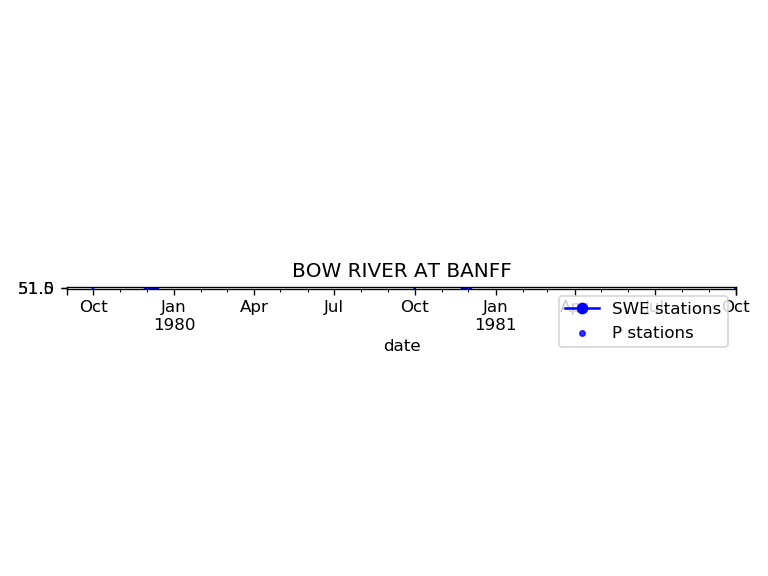

In [18]:
# Plot map of test basin (+ optional buffer) and the extracted stations
fig = stations_basin_map(shp_testbasin_gdf, test_basin_id, SWE_stations_in_basin, met_stations_in_basin, flag=flag_buffer_default, buffer_km=buffer_km_default)

We will now extract the SWE station observations in the test basin and make a few plots.

In [19]:
# Sub-select SWE station observations in test basin and convert to Pandas DataFrame
SWE_testbasin_ds = SWE_stations_ds.sel(station_id = SWE_stations_in_basin["station_id"].values)

# Convert test basin SWE data DataSet to Pandas DataFrame for further analysis
SWE_testbasin_df = SWE_testbasin_ds.to_dataframe().drop(columns=['lon','lat','station_name']).unstack()['snw'].T
SWE_testbasin_df['date'] = SWE_testbasin_df.index.normalize()
SWE_testbasin_df = SWE_testbasin_df.set_index('date')

display(SWE_testbasin_df)

station_id,ALE-05BA801,ALE-05BA802,ALE-05BA806,ALE-05BA808,ALE-05BA810,ALE-05BA811,ALE-05BA812,ALE-05BA813,ALE-05BA814,ALE-05BB803,ALE-05BB803P,ALE-05CA805,ALE-05CA805P,SCD-AL003
date,,,,,,,,,,,,,,
1979-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1979-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1979-10-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1979-10-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1979-10-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.241081,NaN,3.65250,NaN
2022-07-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.81483,NaN
2022-07-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.153671,NaN,3.89600,NaN


<IPython.core.display.Javascript object>


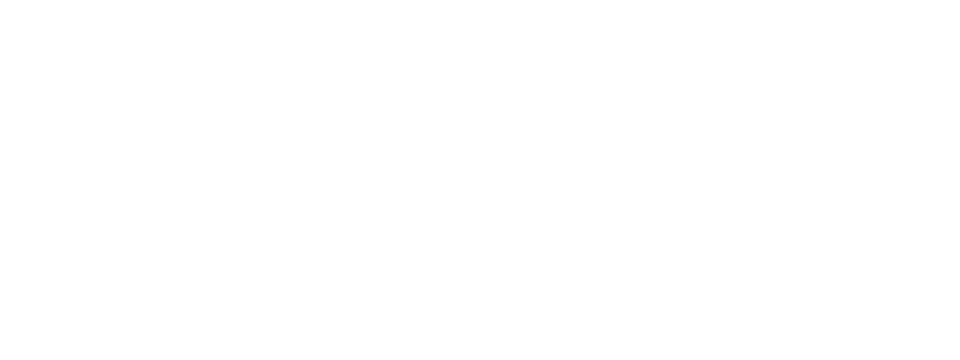

In [20]:
# Plot timeseries of SWE station observations in the test basin
fig = plt.figure(figsize=(8,3))

for s in SWE_testbasin_ds.station_id.values:
    SWE_testbasin_ds.snw.sel(station_id = s).plot(marker='o', alpha=.3, markersize=1, label=s)

plt.title('')
plt.ylabel('SWE [mm]')
plt.xlabel('')
plt.legend(bbox_to_anchor=(1,1.1), loc='upper left', fontsize=8)
plt.tight_layout();

In [21]:
# Save the figure
fig.savefig(settings['plots_path']+"SWE_timeseries_basin"+test_basin_id+".png", dpi=300)

In [22]:
# Close the figure - please run this as it will ensure that we're not overloading the memory unnecessarily
plt.close(fig)

<IPython.core.display.Javascript object>


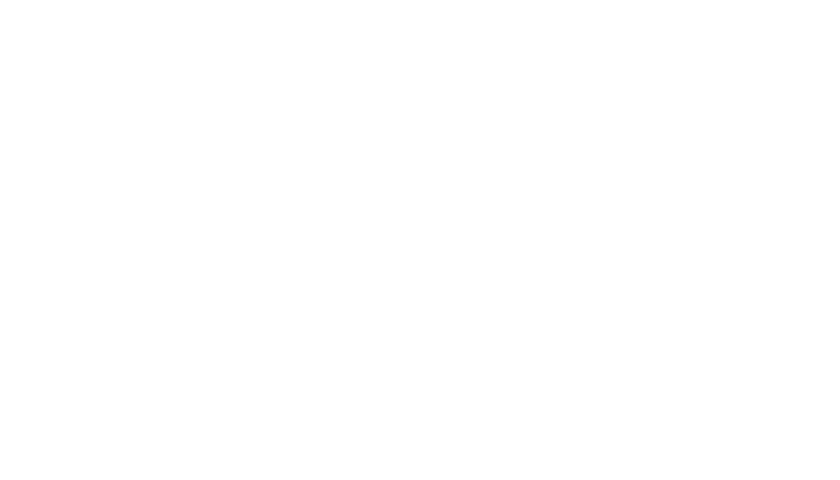

In [23]:
# Plot timeseries of test basin SWE observations climatological means
# We expect to see warnings as some days of the year only have missing values
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    
    fig = plt.figure(figsize=(7,4))

    for s in SWE_testbasin_ds.station_id.values:
        testbasin_SWE_climatology_means = SWE_testbasin_ds.snw.sel(station_id = s).groupby("time.dayofyear").mean(dim=xr.ALL_DIMS, skipna=True)
        testbasin_SWE_climatology_means.plot(marker='o', alpha=.3, markersize=3, label=s)

    plt.title('')
    plt.xticks(np.linspace(0,366,13)[:-1], ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'))
    plt.xlabel('')
    plt.ylabel('SWE [mm]')
    plt.legend(bbox_to_anchor=(1,1), loc='upper left')
    plt.tight_layout();

We can see a striking difference in data availability between the more continuous automatic stations and the discontinuous manual surveys.

In [24]:
# Save the figure
fig.savefig(settings['plots_path']+"SWE_mean_climatology_basin"+test_basin_id+".png", dpi=300)

In [25]:
# Close the figure - please run this as it will ensure that we're not overloading the memory unnecessarily
plt.close(fig)

<IPython.core.display.Javascript object>


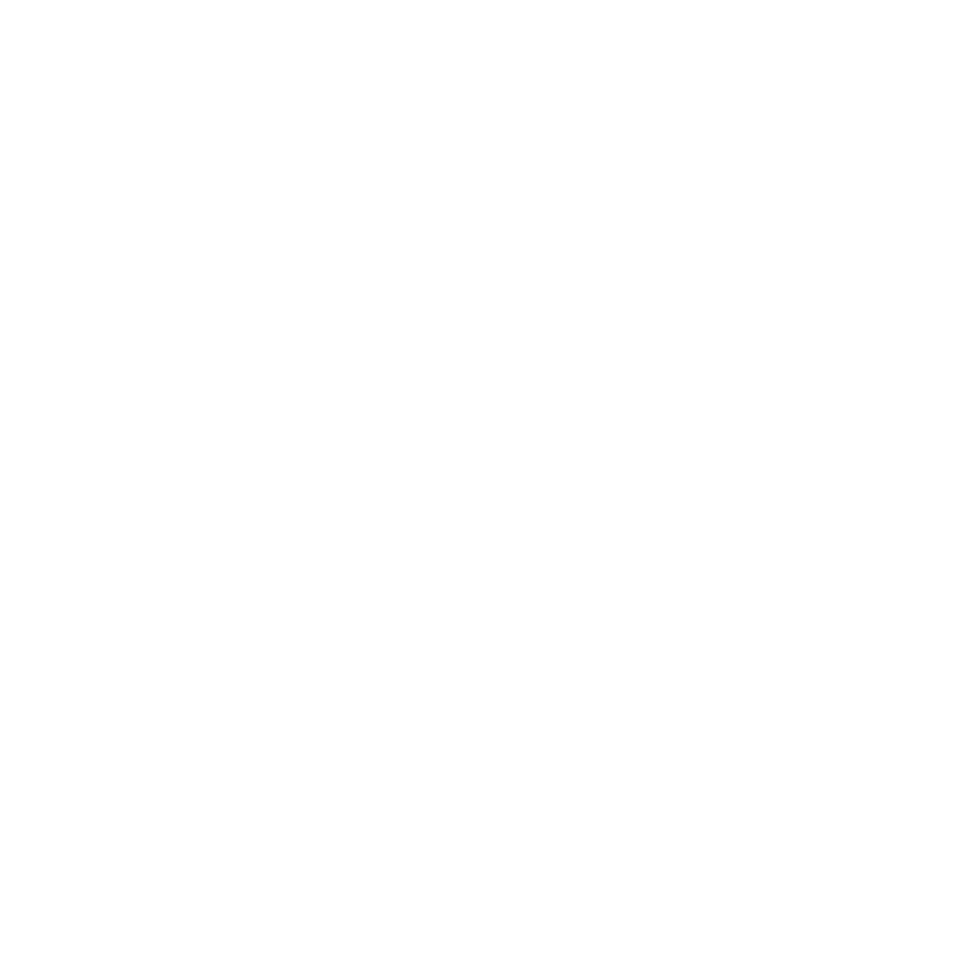

In [26]:
# Plot timeseries of the % of SWE stations with data in the test basin on the first day of each month
fig = data_availability_monthly_plots_1(SWE_stations_in_basin, SWE_testbasin_ds.snw, None, flag=0)

This shows timeseries of the percentage of all SWE stations in the test basin that actually have observations on the first day of each month (subplots). E.g., if all stations have data on the 1st of June 2000, the corresponding bar should show 100%. The reason we focus on the first of each month is because we will only be using these data as they correspond to the hindcast start dates (generated in the next Notebook). 

In [27]:
# Save the figure
fig.savefig(settings['plots_path']+"SWE_monthly_availability_1_basin"+test_basin_id+".png", dpi=300)

In [28]:
# Close the figure - please run this as it will ensure that we're not overloading the memory unnecessarily
plt.close(fig)

We understand that SWE measurements may not always be taken on the first of the month if they are manual measurements. In order to check how far from the first of each month measurements are taken within the test basin, we plot the SWE observations available around the first of day of each month.

<IPython.core.display.Javascript object>


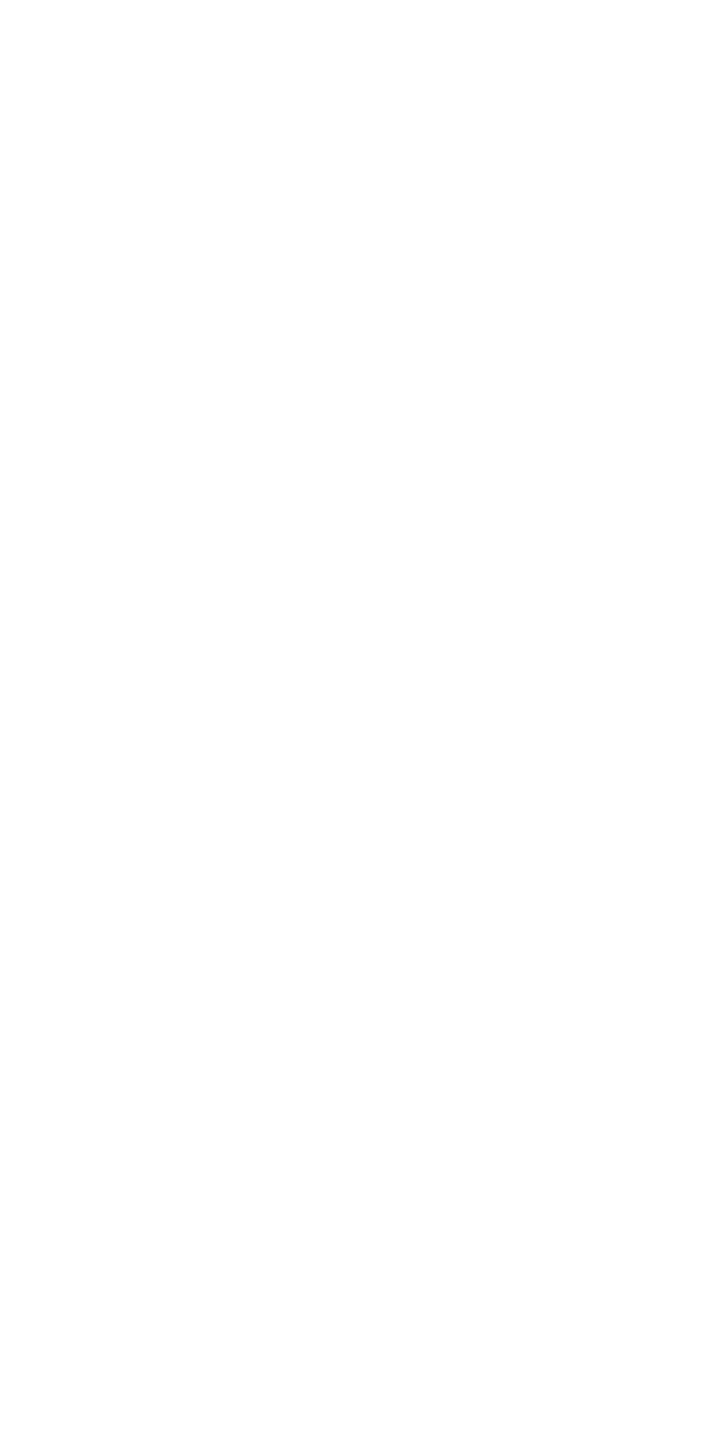

In [29]:
# Plot bar charts of the days with SWE observations around the first day of each month
fig = data_availability_monthly_plots_2(SWE_testbasin_df)

For the Bow at Banff, it looks like most of the manual SWE measurements are taken within a +/- 7 day window around the first day of each month during the snow accumulation period. These results could help us refine the time window used for the infilling (see user-specified variable at the top of this Notebook).

In [30]:
# Save the figure
fig.savefig(settings['plots_path']+"SWE_monthly_availability_2_basin"+test_basin_id+".png", dpi=300)

In [31]:
# Close the figure - please run this as it will ensure that we're not overloading the memory unnecessarily
plt.close(fig)

## Pre-process the SWE and precipitation basin datasets

### Precipitation pre-processing

We will first need to calculate water year station cumulative precipitation outputs to use as a proxy for SWE during the infilling step later on.

In [32]:
# Extract only precipitation observations in the test basin
P_testbasin_da = met_stations_ds.sel(nstn=met_stations_in_basin.index).prcp.dropna(dim='nstn', how='all')

display(P_testbasin_da)

<xarray.DataArray 'prcp' (nstn: 5, nday: 14610)>
array([[ 0.      ,  0.363043,  0.      , ...,  7.1     ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      , ..., 20.466087,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      , ..., 14.470592,  0.62419 ,  0.53611 ],
       [ 0.      ,  0.      ,  0.      , ..., 28.7     ,  0.3     ,  0.3     ],
       [ 0.      ,  0.      ,  0.      , ..., 28.702   ,  0.254   ,  0.254   ]],
      dtype=float32)
Dimensions without coordinates: nstn, nday
Attributes:
    description:  SCD precipitation (mm/day)

If there are no stations with precipitation data in the basin, we can skip all the steps below until the start of the "SWE pre-processing" steps.

In [33]:
# Convert the test basin precipitation DataArray to a Pandas DataFrame for further analysis
P_testbasin_df = P_testbasin_da.to_dataframe().unstack().T
P_testbasin_df['date'] = pd.to_datetime(met_stations_ds.sel(nstn=met_stations_in_basin.index).date.data, format='%Y%m%d')
P_testbasin_df = P_testbasin_df.set_index('date')

# Rename the stations with a straightforward index for the infilling steps
P_testbasin_df.columns = ['precip_' + str(col+1) for col in P_testbasin_df.columns]

display(P_testbasin_df)

,precip_1,precip_2,precip_3,precip_4,precip_5
date,,,,,
1979-01-01,0.000000,0.000000,0.000000,0.000000,0.000
1979-01-02,0.363043,0.000000,0.000000,0.000000,0.000
1979-01-03,0.000000,0.000000,0.000000,0.000000,0.000
1979-01-04,0.000000,0.000000,0.000000,0.000000,0.000
1979-01-05,0.000000,0.000000,0.000000,0.000000,0.000
...,...,...,...,...,...
2018-12-27,0.000000,0.000000,0.000000,0.000000,0.000
2018-12-28,21.799999,0.000000,0.000000,0.000000,0.000
2018-12-29,7.100000,20.466087,14.470592,28.700001,28.702


In [34]:
# Calculate the water year cumulative precipitation for all stations within the test basin
    
# Add water years as an extra column to the P observations Pandas DataFrame
year = []
for i in P_testbasin_df.index:
    if (i.month == month_start_water_year_default and i.day >= day_start_water_year_default) or (i.month > month_start_water_year_default):
        year.append(i.year + 1)
    else:
        year.append(i.year)
P_testbasin_df['water_year'] = year

# Calculate the cumulative precipitation
elem = -1
for y in list(set(P_testbasin_df['water_year'])):
    elem += 1
    P_testbasin_water_year = P_testbasin_df[P_testbasin_df['water_year']==y]
    P_testbasin_water_year_cumul = P_testbasin_water_year.cumsum().drop(['water_year'], axis=1)
    if elem == 0:
        P_cumul_testbasin_df = P_testbasin_water_year_cumul
    else:
        P_cumul_testbasin_df = pd.concat([P_cumul_testbasin_df,P_testbasin_water_year_cumul])
        
display(P_cumul_testbasin_df)

,precip_1,precip_2,precip_3,precip_4,precip_5
date,,,,,
1979-01-01,0.000000,0.000000,0.000000,0.000000,0.000000
1979-01-02,0.363043,0.000000,0.000000,0.000000,0.000000
1979-01-03,0.363043,0.000000,0.000000,0.000000,0.000000
1979-01-04,0.363043,0.000000,0.000000,0.000000,0.000000
1979-01-05,0.363043,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
2018-12-27,49.600010,80.324539,92.246819,50.099991,49.784004
2018-12-28,71.400009,80.324539,92.246819,50.099991,49.784004
2018-12-29,78.500008,100.790627,106.717407,78.799988,78.486008


We can visually check that this gives the expected output for a random station and time period.

In [35]:
# Visual check
P_cumul_testbasin_df['precip_1']['1979-09-01':'1981-10-02'].plot(marker='o', color='b')
plt.tight_layout();

### SWE pre-processing

We now pre-process the SWE data in two steps. We first perform a temporal linear interpolation for each SWE station to infill small data gaps. We then perform quantile mapping from the pre-processed precipitation and SWE data.

In [36]:
# Linear interpolation to fill in small data gaps
SWE_testbasin_interp_da = SWE_testbasin_ds.snw.interpolate_na(method='linear', dim='time', max_gap=datetime.timedelta(days=max_gap_days_default))
SWE_obs_basin_interp_df = SWE_testbasin_interp_da.to_dataframe().drop(columns=['lon','lat','station_name']).unstack()['snw'].T
SWE_obs_basin_interp_df['date'] =  SWE_obs_basin_interp_df.index.normalize()
SWE_obs_basin_interp_df = SWE_obs_basin_interp_df.set_index('date')

In [37]:
# Save flags for linear interpolation to a new Pandas dataframe (observations = 0; estimates = 1)
flags_interp_testbasin_da = SWE_testbasin_interp_da.copy().fillna(-999)
original_da = SWE_testbasin_ds.snw.copy().fillna(-999)
flags_interp_testbasin_da = xr.where(flags_interp_testbasin_da==original_da, 0, 1)
flags_interp_testbasin_df = flags_interp_testbasin_da.to_dataframe().drop(columns=['lon','lat','station_name']).unstack()['snw'].T
flags_interp_testbasin_df['date'] =  flags_interp_testbasin_df.index.normalize()
flags_interp_testbasin_df = flags_interp_testbasin_df.set_index('date')

We now need to combine the pre-processed precipitation and SWE data into a single dataframe for the quantile mapping step.

In [38]:
# Combine test basin SWE and precipitation data in a single Pandas DataFrame (if there is precipitation data available)
if len(P_testbasin_da.nstn) == 0:
    SWE_P_testbasin_df = SWE_obs_basin_interp_df.copy()
else:
    SWE_P_testbasin_df = SWE_obs_basin_interp_df.merge(P_cumul_testbasin_df, left_index=True, right_index=True, how='outer')
    
display(SWE_P_testbasin_df)

,ALE-05BA801,ALE-05BA802,ALE-05BA806,ALE-05BA808,ALE-05BA810,ALE-05BA811,ALE-05BA812,ALE-05BA813,ALE-05BA814,ALE-05BB803,ALE-05BB803P,ALE-05CA805,ALE-05CA805P,SCD-AL003,precip_1,precip_2,precip_3,precip_4,precip_5
date,,,,,,,,,,,,,,,,,,,
1979-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,0.0,0.0
1979-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.363043,0.0,0.0,0.0,0.0
1979-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.363043,0.0,0.0,0.0,0.0
1979-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.363043,0.0,0.0,0.0,0.0
1979-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.363043,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.241081,NaN,3.65250,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.697376,NaN,3.81483,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.153671,NaN,3.89600,NaN,NaN,NaN,NaN,NaN,NaN


In this second step, we perform quantile mapping to fill gaps in the SWE observations using neighbouring SWE or precipitation stations data. For each target station (i.e., station with a gap to fill) and each date for which date is missing, we identify a donor station as the station with: 
- data for this date, 
- a cdf for this doy,
- and the highest correlation to the target station (correlation above a minimum threshold, set in the user-specified variables above).
Once an optimal donor station has been selected for a target station & given date, we fill in the gap using quantile mapping.

In [39]:
# Perform gap filling for the original dataset (no artificial gaps, flag=0)
# Note: this may take quite a while to run, depending on the number of gaps to fill
SWE_testbasin_gapfilled_df, flags_gapfill_testbasin_df, donor_stations_gapfill_testbasin_df = qm_gap_filling(SWE_P_testbasin_df.copy(), window_days=window_days_default, min_obs_corr=min_obs_corr_default, min_obs_cdf=min_obs_cdf_default, min_corr=min_corr_default)

In [40]:
# Combine linear interpolation and quantile mapping flags into a single Pandas dataframe
flags_testbasin_df = flags_interp_testbasin_df + flags_gapfill_testbasin_df

In [41]:
# Combine gap filled dataset and metadata into a single dataset
SWE_P_gapfill_testbasin_da = xr.DataArray(data=SWE_testbasin_gapfilled_df.values, coords=dict(time=SWE_testbasin_gapfilled_df.index.values, station_id=SWE_testbasin_gapfilled_df.columns.values), dims=['time','station_id'], name='SWE', attrs={'long_name':'Surface snow water equivalent','units':'kg m**-2'})
flags_testbasin_da = xr.DataArray(data=flags_testbasin_df.values, coords=dict(time=flags_testbasin_df.index.values, station_id=flags_testbasin_df.columns.values), dims=['time','station_id'], name='flag', attrs={'description':'observations = 0; estimates = 1'})
donor_stations_gapfill_testbasin_da = xr.DataArray(data=donor_stations_gapfill_testbasin_df.values, coords=dict(time=donor_stations_gapfill_testbasin_df.index.values, station_id=donor_stations_gapfill_testbasin_df.columns.values), dims=['time','station_id'], name='donor_stations', attrs={'description':'station_id of donor stations used for gap filling'})
SWE_testbasin_gapfilled_ds = xr.merge([SWE_P_gapfill_testbasin_da, flags_testbasin_da, donor_stations_gapfill_testbasin_da])
lats = SWE_testbasin_ds.sel(station_id=SWE_testbasin_gapfilled_df.columns.values).lat.values
lons = SWE_testbasin_ds.sel(station_id=SWE_testbasin_gapfilled_df.columns.values).lon.values
names = SWE_testbasin_ds.sel(station_id=SWE_testbasin_gapfilled_df.columns.values).station_name.values
SWE_testbasin_gapfilled_ds = SWE_testbasin_gapfilled_ds.assign_coords({'lat':('station_id',lats),'lon':('station_id',lons),'station_name':('station_id',names)})

display(SWE_testbasin_gapfilled_ds)

<xarray.Dataset>
Dimensions:         (station_id: 14, time: 15918)
Coordinates:
  * time            (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2022-07-31
  * station_id      (station_id) object 'ALE-05BA801' ... 'SCD-AL003'
    lat             (station_id) float64 51.42 51.43 51.42 ... 51.53 51.54 51.18
    lon             (station_id) float64 -116.2 -116.2 -116.2 ... -116.1 -115.6
    station_name    (station_id) object 'BOW RIVER' ... 'BANFF'
Data variables:
    SWE             (time, station_id) float32 nan nan nan nan ... nan 3.896 nan
    flag            (time, station_id) float64 nan nan nan nan ... 0.0 0.0 0.0
    donor_stations  (time, station_id) object nan nan nan nan ... nan nan nan

<IPython.core.display.Javascript object>


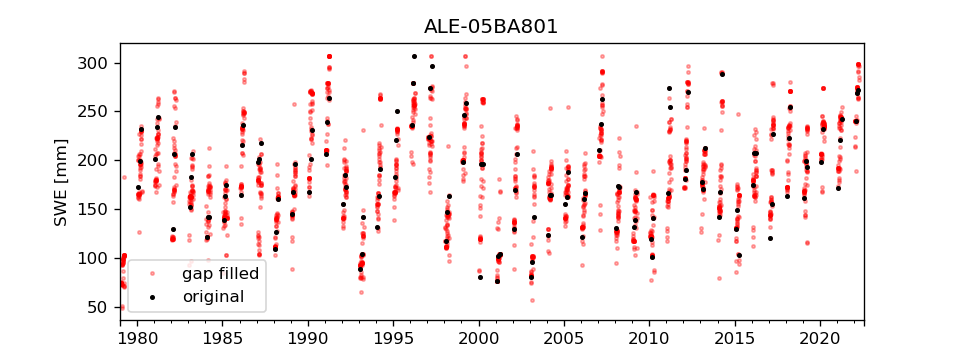

In [42]:
# Plot the first SWE station in the dataset to visually check gap filling results
plt.figure(figsize=(8,3))
SWE_testbasin_gapfilled_df.iloc[:,0].plot(color='r', marker='o', ms=2, label='gap filled', lw=0, alpha=.3)
SWE_P_testbasin_df.iloc[:,0].plot(color='k', marker='o', ms=2, label='original', lw=0)
plt.title(SWE_P_testbasin_df.iloc[:,0].name)
plt.xlabel('')
plt.ylabel('SWE [mm]')
plt.legend();

<IPython.core.display.Javascript object>


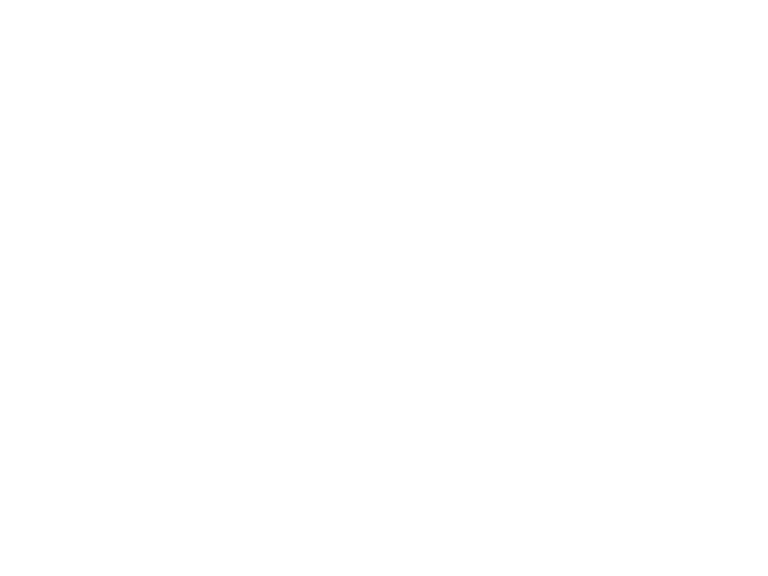

In [43]:
# Plot a bar chart of the number of times each donor station was used for infilling
count = []

for s in SWE_P_testbasin_df.columns.values:
    count_s = SWE_testbasin_gapfilled_ds.donor_stations.where(SWE_testbasin_gapfilled_ds.donor_stations==s).count().data
    count.append(count_s)

fig = plt.figure()
plt.bar(SWE_P_testbasin_df.columns.values, count, color='b')
plt.xticks(rotation=90)
plt.xlabel('Donor stations')
plt.ylabel('# times used for infilling')
plt.tight_layout();

In [44]:
# Save the figure
fig.savefig(settings['plots_path']+"donor_stations_gapfilling_basin"+test_basin_id+".png", dpi=300)

In [45]:
# Close the figure - please run this as it will ensure that we're not overloading the memory unnecessarily
plt.close(fig)

<IPython.core.display.Javascript object>


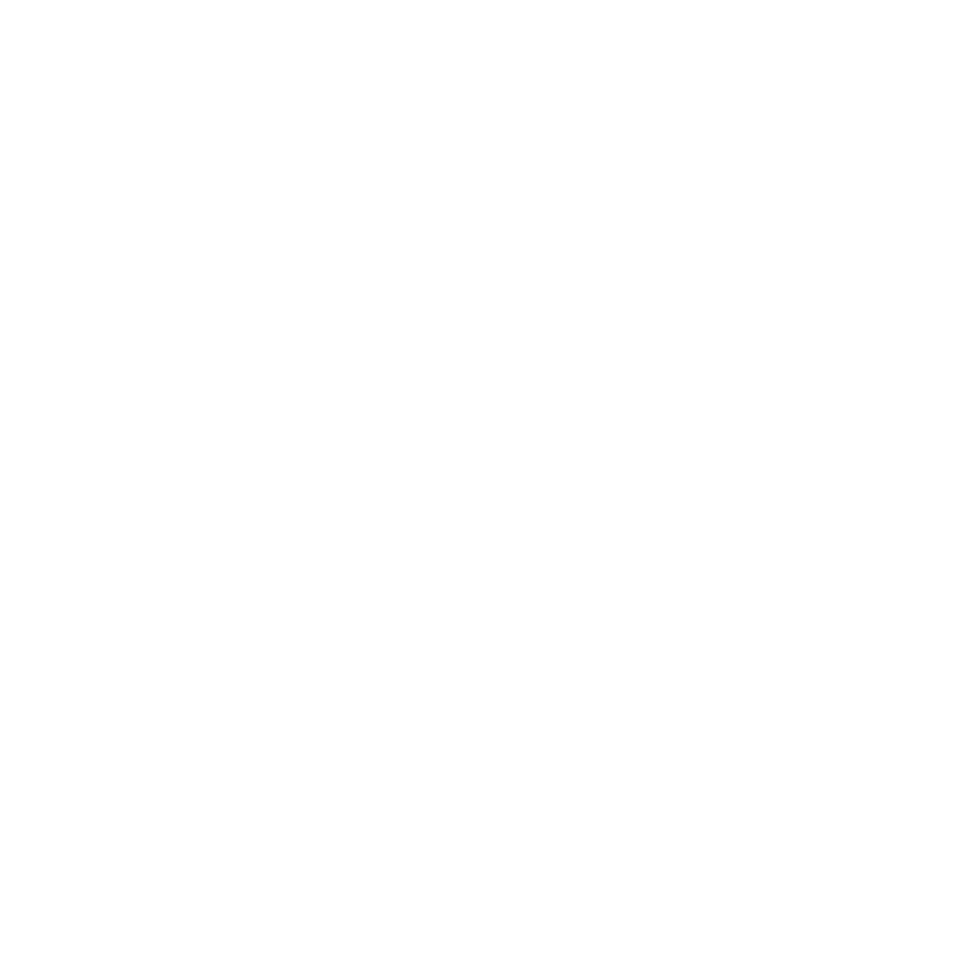

In [46]:
# Plot timeseries of the % of SWE stations with data in the test basin on the first day of each month, for the original data & after gap filling (flag=1)
fig = data_availability_monthly_plots_1(SWE_stations_in_basin, SWE_testbasin_ds.snw, SWE_testbasin_gapfilled_ds.SWE, flag=1)

In [47]:
# Save the figure
fig.savefig(settings['plots_path']+"SWE_monthly_availability_1_after_gap_filling_basin"+test_basin_id+".png", dpi=300)

In [48]:
# Close the figure - please run this as it will ensure that we're not overloading the memory unnecessarily
plt.close(fig)

### Artificial gap filling and evaluation
We remove data artificially from the SWE station observations to test the performance of the gap filling. Note that we only do this for the first of each month to limit the computation time.

<IPython.core.display.Javascript object>


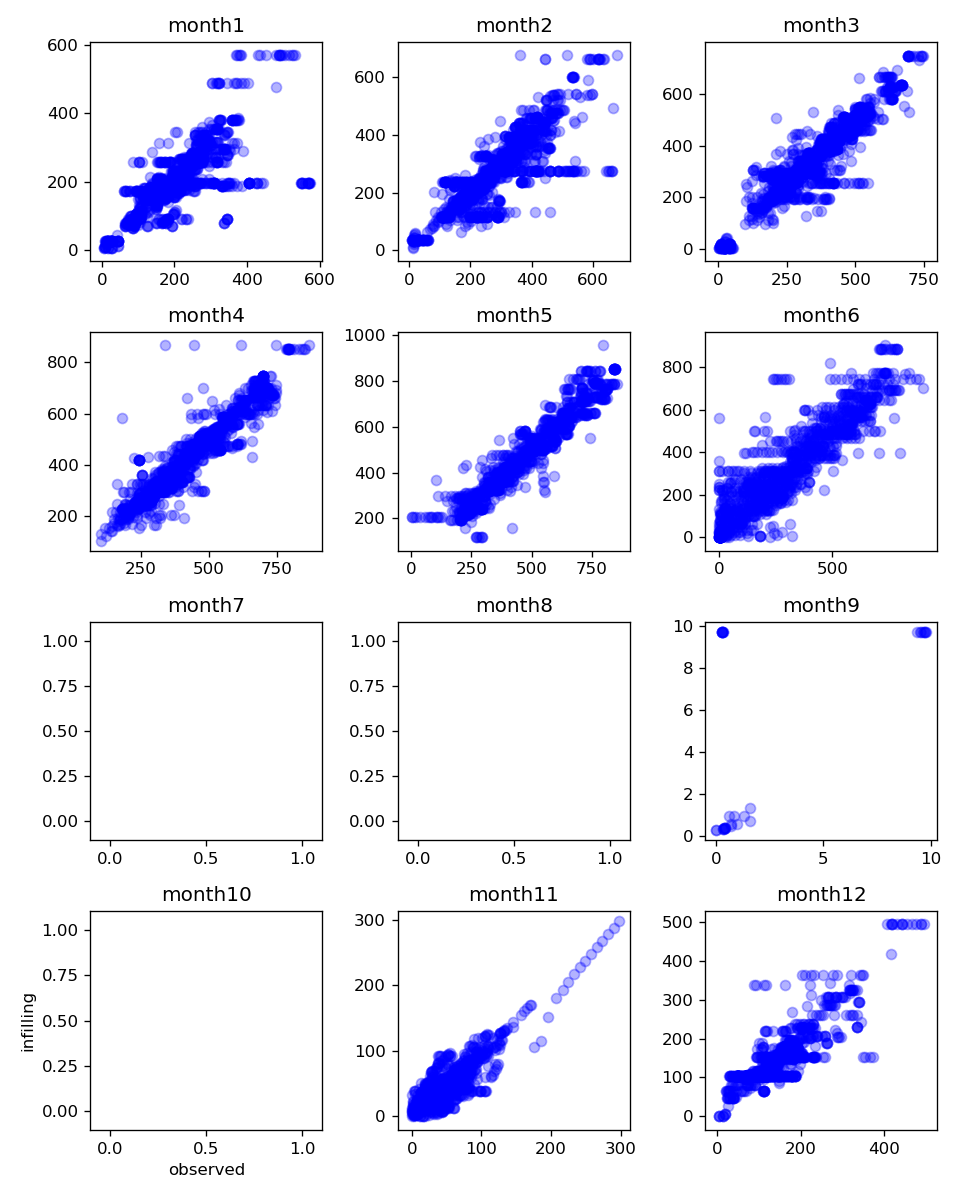

Working on month 1
Working on month 2
Working on month 3
Working on month 4
Working on month 5
Working on month 6
Working on month 7
Working on month 8
Working on month 9
Working on month 10
Working on month 11
Working on month 12


In [49]:
# Perform artificial gap filling evaluation and plot the results (flag=1)
# Note: this may take quite a while to run, depending on the number of gaps to fill
pd.set_option("mode.chained_assignment", None) # suppresses the "SettingWithCopyWarning"

evaluation_artificial_gapfill_testbasin_dict, fig = artificial_gap_filling(SWE_P_testbasin_df.copy(), iterations=iterations_default, artificial_gap_perc=artificial_gap_perc_default, window_days=window_days_default, min_obs_corr=min_obs_corr_default, min_obs_cdf=min_obs_cdf_default, min_corr=min_corr_default, min_obs_KGE=min_obs_KGE_default, flag=1)

<IPython.core.display.Javascript object>


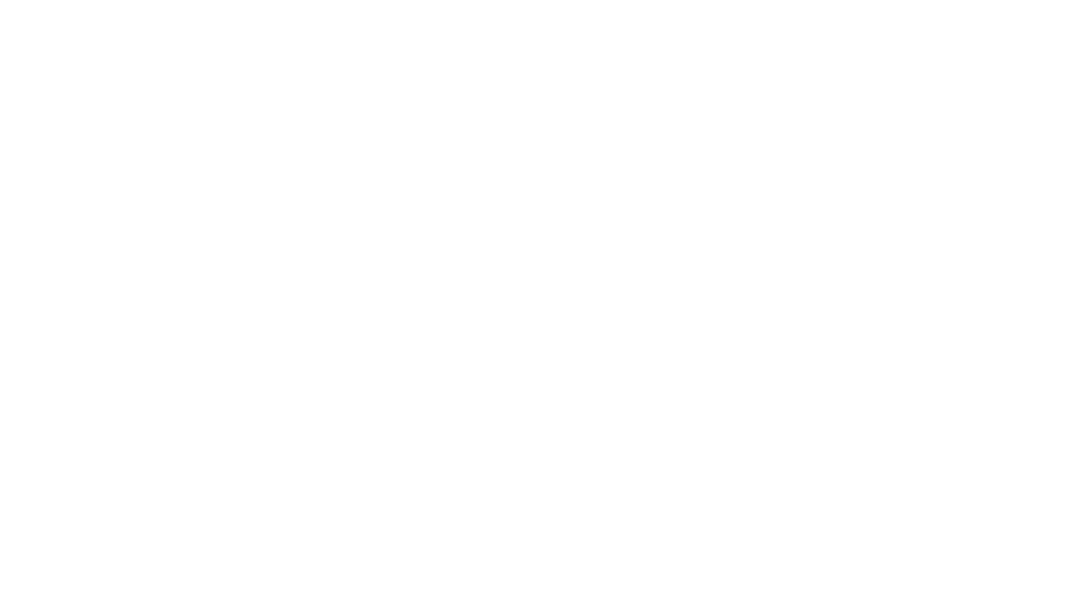

In [50]:
# Plot artificial gap filling evaluation results
fig = plots_artificial_gap_evaluation(evaluation_artificial_gapfill_testbasin_dict)

The boxplots contain results for all SWE stations. For the Bow at Banff, we can see some low scores. This can sometimes happens for certain SWE stations with very few gaps to fill. If various donor stations are used to fill out these gaps, then there are some inconsistencies across infilling values and the overall correlation between the infilling values and the observations is poor.

In [51]:
# Save the figure
fig.savefig(settings['plots_path']+"artificial_gap_filling_evaluation_basin"+test_basin_id+".png", dpi=300)

In [52]:
# Close the figure - please run this as it will ensure that we're not overloading the memory unnecessarily
plt.close(fig)

## Save data
Save the output gap-filled SWE data so we can read them in other Notebooks.

In [53]:
# Save the data
SWE_testbasin_gapfilled_ds.to_netcdf(settings['output_data_path']+"SWE_1979_2022_gapfilled_basin"+test_basin_id+".nc", format="NETCDF4")